# Introduction

In this notebook we develop a Distributed Deep Deterministic Policy Gradient (D3PG) model with NoisyNets and Prioritised Experience Replay and analyse its performance on Unity's Tennis environment with two agents.

This is part of the last project: *Collaboration and Competition* of **Deep Reinforcement Learning for Enterprise** Course in *Udacity*.

## 0 - Importing Packages

Importing all required packages, utilities and initialising the environment.

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from training_d3pg_agent_nn_per import d3pg
from d3pg_agent_nn_per import Agent

def maxlen(dic):
    l = 0
    for e in dic.values():
        if len(e) > l:
            l = len(e)
    return l

def dic_fix(dic):
    dicF = {}
    ml = maxlen(dic)
    for i , e in enumerate(dic.values()):
        new = [None] * (ml - len(e))
        dicF[i] = e + new
    return dicF

env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 1 - Training a D3PG model with NoisyNets

Defining a dictionary with all hyperparameters inputs in the learning model. Using the values mentioned in the Results section of Barth-Maron's paper.

In [6]:
dic = {'n_episodes': 5000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.000001,    # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.005,            # uniform noise process initial scale parameter
       'epsilon_halflife': 200,     # no episodes to achieve half of the noise
       'file': 'chpt_d3pg_nn'}      # file name to save agent's net weights

In [7]:
scores_dic = {}
times_dic = {}

for i in range(10):
    print('\nTraining session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=True, NoiseNet=True, PER=False)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_nn_analysis.csv')
times_df.to_csv('times_nn_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.00	Time Split: 62.92			 
Episode 200	Average Score: 0.00	Time Split: 69.86			 
Episode 300	Average Score: 0.00	Time Split: 66.93			 
Episode 400	Average Score: 0.00	Time Split: 67.14			 
Episode 500	Average Score: 0.00	Time Split: 66.88			 
Episode 600	Average Score: 0.00	Time Split: 67.57			 
Episode 700	Average Score: 0.00	Time Split: 71.12			 
Episode 800	Average Score: 0.00	Time Split: 74.43			 
Episode 900	Average Score: 0.00	Time Split: 76.57			 
Episode 1000	Average Score: 0.00	Time Split: 80.55			 
Episode 1100	Average Score: 0.00	Time Split: 86.05			 
Episode 1200	Average Score: 0.00	Time Split: 86.78			 
Episode 1300	Average Score: 0.00	Time Split: 89.72			 
Episode 1400	Average Score: 0.00	Time Split: 91.83			 
Episode 1500	Average Score: 0.00	Time Split: 97.61			 
Episode 1600	Average Score: 0.00	Time Split: 99.22			 
Episode 1700	Average Score: 0.00	Time Split: 99.54			 
Episode 1800	Average Score: 0.00	Time Split: 99.78			

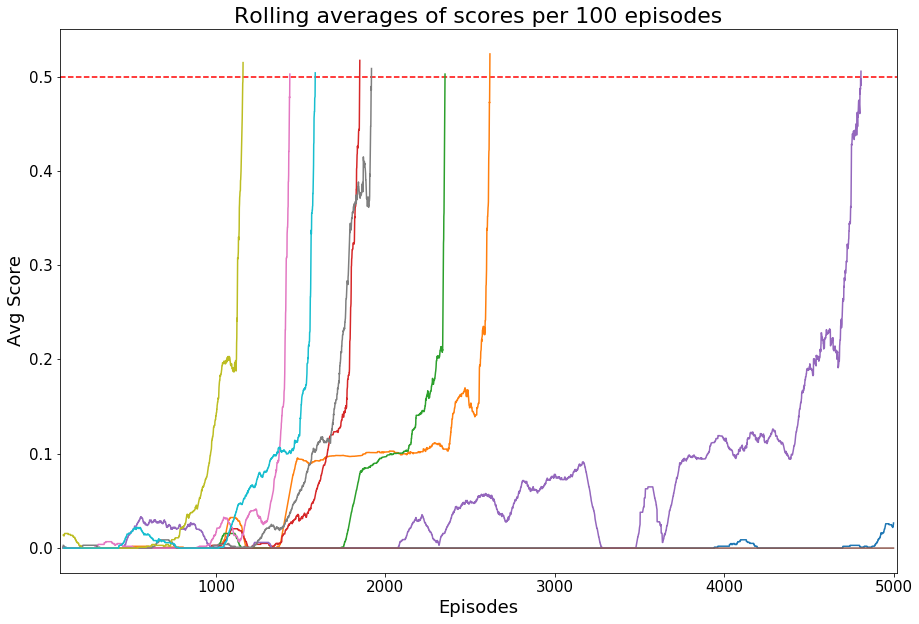

In [9]:
scores_df = pd.read_csv('scores_nn_analysis.csv', index_col=0)
times_df = pd.read_csv('times_nn_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(80,5020), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGNN.png")

In [10]:
completed_sessions = scores_df.iloc[:, pd.Series(np.isnan(scores_df.iloc[4999])).values].count() - 100
completed_sessions.describe()

count       8.000000
mean     2116.625000
std      1148.695277
min      1061.000000
25%      1449.500000
50%      1784.500000
75%      2319.250000
max      4708.000000
dtype: float64

The D3PG model with NoisyNets **solves the environment 80% of the times** when maximum number of episodes per training session is 5000. In successful training sessions, it takes on average **2100 episodes**. The distribution shows a dispersion of *1150 episodes** standard deviation. So no perceived benefit from the original model.

* Further tuning of initial error up and half life down would be our next exploration in terms of improving the model.

## 2 - Training a D3PG model with PER

We now use a D3PG model with Prioritised Experience Replay. We also increase the noise parameter to incentivise exploration.

In [2]:
dic = {'n_episodes': 5000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0,           # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.9,              # uniform noise process initial scale parameter
       'epsilon_halflife': 300,     # no episodes to achieve half of the noise
       'file': 'chpt_d3pg_per'}     # file name to save agent's net weights

In [3]:
scores_dic = {}
times_dic = {}

for i in range(10):
    print('\nTraining session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=True, NoiseNet=False, PER=True)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_per_analysis.csv')
times_df.to_csv('times_per_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.00	Time Split: 99.87			 
Episode 200	Average Score: 0.00	Time Split: 113.24			 
Episode 300	Average Score: 0.00	Time Split: 114.50			 
Episode 400	Average Score: 0.00	Time Split: 113.72			 
Episode 500	Average Score: 0.00	Time Split: 112.49			 
Episode 600	Average Score: 0.00	Time Split: 112.86			 
Episode 700	Average Score: 0.00	Time Split: 112.78			 
Episode 800	Average Score: 0.00	Time Split: 113.69			 
Episode 900	Average Score: 0.00	Time Split: 113.74			 
Episode 1000	Average Score: 0.00	Time Split: 113.39			 
Episode 1100	Average Score: 0.00	Time Split: 113.45			 
Episode 1200	Average Score: 0.00	Time Split: 113.02			 
Episode 1300	Average Score: 0.00	Time Split: 112.60			 
Episode 1400	Average Score: 0.02	Time Split: 152.82			 
Episode 1500	Average Score: 0.07	Time Split: 212.41			 
Episode 1600	Average Score: 0.09	Time Split: 266.60			 
Episode 1700	Average Score: 0.10	Time Split: 264.24			 
Episode 1800	Average Score: 0.12	Time

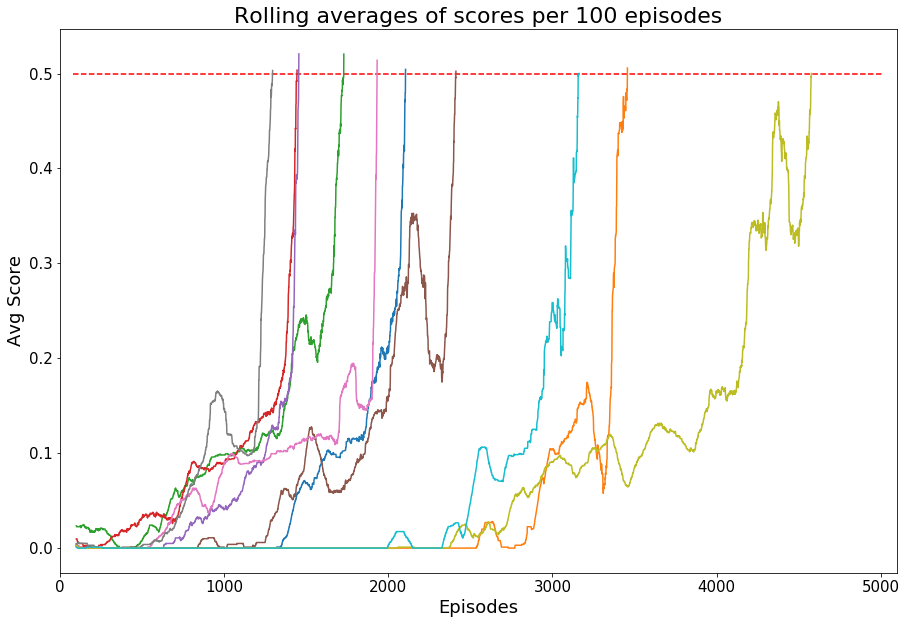

In [4]:
scores_df = pd.read_csv('scores_per_analysis.csv',index_col=0)
times_df = pd.read_csv('times_per_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGPER.png")

In [6]:
scores_df = pd.read_csv('scores_per_analysis.csv',index_col=0)
total_episodes = scores_df.count() - 100
total_episodes.describe()

count      10.000000
mean     2258.000000
std      1065.052529
min      1196.000000
25%      1424.500000
50%      1919.500000
75%      2876.250000
max      4479.000000
dtype: float64

A D3PG model with PER **solves the environment 100% of the times** when maximum number of episodes per training session is 5000. This is a better performance than all the other D3PG models so far. It takes on average **2000 episodes**. This is a worse performance than the BM D3PG model. The distribution shows a dispersion of **1000 episodes** standard deviation.

## 3 - Training a D3PG model with NoisyNets and PER

We finally use a D3PG model with both Prioritised Experience Replay and Noisy Nets.

In [2]:
dic = {'n_episodes': 5000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.000001,    # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.05,             # uniform noise process initial scale parameter
       'epsilon_halflife': 100,     # no episodes to achieve half of the noise
       'file': 'chpt_d3pg_nn_per'}  # file name to save agent's net weights

In [3]:
scores_dic = {}
times_dic = {}

for i in range(10):
    print('\nTraining session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=True, NoiseNet=False, PER=True)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_nn_per_analysis.csv')
times_df.to_csv('times_nn_per_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.01	Time Split: 103.58			 
Episode 200	Average Score: 0.00	Time Split: 113.30			 
Episode 300	Average Score: 0.00	Time Split: 114.98			 
Episode 400	Average Score: 0.00	Time Split: 127.16			 
Episode 500	Average Score: 0.03	Time Split: 179.62			 
Episode 600	Average Score: 0.02	Time Split: 154.03			 
Episode 700	Average Score: 0.02	Time Split: 155.23			 
Episode 800	Average Score: 0.01	Time Split: 141.37			 
Episode 900	Average Score: 0.02	Time Split: 151.54			 
Episode 1000	Average Score: 0.01	Time Split: 134.92			 
Episode 1100	Average Score: 0.06	Time Split: 224.80			 
Episode 1200	Average Score: 0.08	Time Split: 255.88			 
Episode 1300	Average Score: 0.09	Time Split: 301.80			 
Episode 1400	Average Score: 0.07	Time Split: 246.69			 
Episode 1500	Average Score: 0.14	Time Split: 461.92			 
Episode 1600	Average Score: 0.27	Time Split: 950.33			 
Episode 1648	Average Score: 0.50	Time Elapsed: 4877.09
Environment solved in 1548 episodes!	

Episode 200	Average Score: 0.00	Time Split: 111.65			 
Episode 300	Average Score: 0.00	Time Split: 110.11			 
Episode 400	Average Score: 0.00	Time Split: 115.55			 
Episode 500	Average Score: 0.00	Time Split: 111.24			 
Episode 600	Average Score: 0.00	Time Split: 112.80			 
Episode 700	Average Score: 0.00	Time Split: 111.37			 
Episode 800	Average Score: 0.00	Time Split: 113.29			 
Episode 900	Average Score: 0.00	Time Split: 121.19			 
Episode 1000	Average Score: 0.00	Time Split: 117.90			 
Episode 1100	Average Score: 0.00	Time Split: 119.72			 
Episode 1200	Average Score: 0.00	Time Split: 122.38			 
Episode 1300	Average Score: 0.00	Time Split: 126.78			 
Episode 1400	Average Score: 0.00	Time Split: 133.39			 
Episode 1500	Average Score: 0.00	Time Split: 143.47			 
Episode 1600	Average Score: 0.00	Time Split: 138.72			 
Episode 1700	Average Score: 0.00	Time Split: 139.39			 
Episode 1800	Average Score: 0.00	Time Split: 137.07			 
Episode 1900	Average Score: 0.00	Time Split: 137.84			 


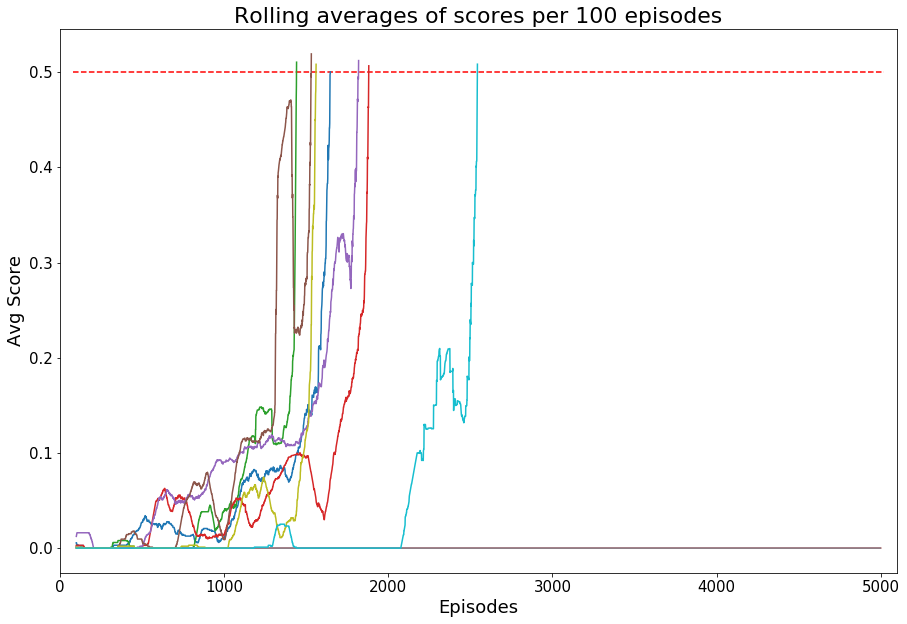

In [4]:
scores_df = pd.read_csv('scores_nn_per_analysis.csv',index_col=0)
times_df = pd.read_csv('times_nn_per_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGNNPER.png")

In [5]:
completed_sessions = scores_df.iloc[:, pd.Series(np.isnan(scores_df.iloc[4999])).values].count() - 100
completed_sessions.describe()

count       7.000000
mean     1675.571429
std       373.429091
min      1342.000000
25%      1446.500000
50%      1548.000000
75%      1751.000000
max      2444.000000
dtype: float64

 The D3PG model with Noisy Nets and PER **solved the environment 70% of the times** when maximum number of episodes per training session is 5000. In successful training sessions, it takes on average **1600 episodes**. The distribution shows a dispersion of **375 episodes** standard deviation.

It is a performance close to the Original D3PG model we first tried. Although with one fewer solved session, when solved the number of episodes was at the same level as the best performance so far and with half of the standard deviation.

## 4 - Watch Trained Agents

In [6]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations
state = states[0]
state_size = len(state)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents) 
agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size)
agent.actor_local.load_state_dict(torch.load('chpt_d3pg_nn_per_actor.pth'))

while True:
    actions = agent.act(states, add_noise=False)        # select an action  
    env_info = env.step(actions)[brain_name]            # send all actions to the environment
    states = env_info.vector_observations               # get next state   
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score     
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(np.mean(scores)))

Total score for this episode: 2.650000039488077


* Less tremour on this agent.